Fitting a Simple Additive Model in Python - By Pang Sheng Wei

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import patsy
import scipy as sp
import seaborn as sns
from statsmodels import api as sm

/Users/Dylan/anaconda/envs/tensorflow/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Importing the Lidar [Dataset](https://en.wikipedia.org/wiki/Lidar), which is well-suited to additive modeling because the relationship between the variables is highly non-linear.

In [6]:
df = pd.read_csv('http://www.stat.cmu.edu/~larry/all-of-nonpar/=data/lidar.dat',
                 sep=' *', engine='python')
df['std_range'] = (df.range - df.range.min()) / df.range.ptp()

n = df.shape[0]
df.head()

/Users/Dylan/anaconda/envs/tensorflow/lib/python3.5/site-packages/pandas/io/parsers.py:2137: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/Dylan/anaconda/envs/tensorflow/lib/python3.5/site-packages/pandas/io/parsers.py:2139: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


,range,logratio,std_range
0,390,-0.050356,0.000000
1,391,-0.060097,0.003030
2,393,-0.041901,0.009091
3,394,-0.050985,0.012121
4,396,-0.059913,0.018182


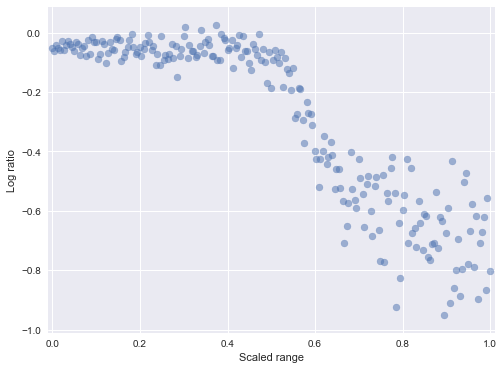

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

blue = sns.color_palette()[0]
ax.scatter(df.std_range, df.logratio, c=blue, alpha=0.5);

ax.set_xlim(-0.01, 1.01);
ax.set_xlabel('Scaled range');
ax.set_ylabel('Log ratio');

An additive model represents the relationship between explanatory variables $\mathbf{x}$ and a response variable $y$ as a sum of smooth functions of the explanatory variables

$$y = \beta_0 + f_1(x_1) + f_2(x_2) + \cdots + f_k(x_k) + \varepsilon.$$

The smooth functions $f_i$ can be estimated using a variety of nonparametric techniques.  Following Chapter 3 of Wood's book, we will fit our additive model using penalized regression splines.

Since our LIDAR data set has only one explanatory variable, our additive model takes the form

$$y = \beta_0 + f(x) + \varepsilon.$$

We fit this model by minimizing the penalized residual sum of squares

$$PRSS = \sum_{i = 1}^n \left(y_i - \beta_0 - f(x_i)\right)^2 + \lambda \int_0^1 \left(f''(x)\right)^2\ dx.$$

The penalty term

$$\int_0^1 \left(f''(x)\right)^2\ dx$$

causes us to only choose less smooth functions if they fit the data much better.  The smoothing parameter $\lambda$ controls the rate at which decreased smoothness is traded for a better fit.

In the penalized regression splines model, we must also choose basis functions $\varphi_1, \varphi_2, \ldots, \varphi_k$, which we then use to express the smooth function $f$ as

$$f(x) = \beta_1 \varphi_1(x) + \beta_2 \varphi_2(x) + \cdots + \beta_k \varphi_k(x).$$

With these basis functions in place, if we define $\mathbf{x}_i = [1\ x_i\ \varphi_2(x_i)\ \cdots \varphi_k(x_i)]$ and

$$\mathbf{X} = \begin{bmatrix}
    \mathbf{x}_1 \\
    \vdots \\
    \mathbf{x}_n
 \end{bmatrix},$$
 
the model $y_i = \beta_0 + f(x_i) + \varepsilon$ can be rewritten as $\mathbf{y} = \mathbf{X} \beta + \varepsilon$.  It is tedious but not difficult to show that when $f$ is expressed as a linear combination of basis functions, there is always a [positive semidefinite](https://en.wikipedia.org/wiki/Positive-definite_matrix#Negative-definite.2C_semidefinite_and_indefinite_matrices) matrix $\mathbf{S}$ such that

$$\int_0^1 \left(f''(x)\right)^2\ dx = \beta^{\intercal} \mathbf{S} \beta.$$

Since $\mathbf{S}$ is positive semidefinite, it has a square root $\mathbf{B}$ such that $\mathbf{B}^{\intercal} \mathbf{B} = \mathbf{S}$.  The penalized residual sum of squares objective function can then be written as

$$
\begin{align*}
    PRSS
        & = (\mathbf{y} - \mathbf{X} \beta)^{\intercal} (\mathbf{y} - \mathbf{X} \beta) + \lambda \beta^{\intercal} \mathbf{B}^{\intercal} \mathbf{B} \beta
          = (\mathbf{\tilde{y}} - \mathbf{\tilde{X}} \beta)^{\intercal} (\mathbf{\tilde{y}} - \mathbf{\tilde{X}} \beta),
\end{align*}
$$

where

$$\mathbf{\tilde{y}} = \begin{bmatrix}
    \mathbf{y} \\
    \mathbf{0}_{k + 1}
\end{bmatrix}
$$

and

$$\mathbf{\tilde{X}} = \begin{bmatrix}
    \mathbf{X} \\
    \sqrt{\lambda}\ \mathbf{B}
\end{bmatrix}. 
$$

Therefore the augmented data matrices $\mathbf{\tilde{y}}$ and $\mathbf{\tilde{X}}$ allow us to express the penalized residual sum of squares for the original model as the residual sum of squares of the OLS model $\mathbf{\tilde{y}} = \mathbf{\tilde{X}} \beta + \tilde{\varepsilon}$.  This augmented model allows us to use widely available machinery for fitting OLS models to fit the additive model as well.

The last step before we can fit the model in Python is to choose the basis functions $\varphi_i$.  Again, following Chapter 3 of Wood's book, we let

$$R(x, z) = \frac{1}{4} \left(\left(z - \frac{1}{2}\right)^2 - \frac{1}{12}\right) \left(\left(x - \frac{1}{2}\right)^2 - \frac{1}{12}\right) - \frac{1}{24} \left(\left(\left|x - z\right| - \frac{1}{2}\right)^4 - \frac{1}{2} \left(\left|x - z\right| - \frac{1}{2}\right)^2 + \frac{7}{240}\right).$$

In [8]:
def R(x, z):
    return ((z - 0.5)**2 - 1 / 12) * ((x - 0.5)**2 - 1 / 12) / 4 - ((np.abs(x - z) - 0.5)**4 - 0.5 * (np.abs(x - z) - 0.5)**2 + 7 / 240) / 24

R = np.frompyfunc(R, 2, 1)

def R_(x):
    return R.outer(x, knots).astype(np.float64)

Though this function is quite complicated, we will see that it has some very conveient properties. We must also choose a set of knots  zizi  in  [0,1][0,1] ,  i=1,2,…,qi=1,2,…,q .

In [9]:
q = 20

knots = df.std_range.quantile(np.linspace(0, 1, q))

Here we have used twenty knots situatied at percentiles of `std_range`.

Now we define our basis functions as $\varphi_1(x) = x$, $\varphi_{i}(x) = R(x, z_{i - 1})$ for $i = 2, 3, \ldots q + 1$.

Our model matrices $\mathbf{y}$ and $\mathbf{X}$ are therefore

In [11]:
y, X = patsy.dmatrices('logratio ~ std_range + R_(std_range)', data=df)

Note that, by default, `patsy` always includes an intercept column in `X`.

The advantage of the function $R$ is the the penalty matrix $\mathbf{S}$ has the form

$$S = \begin{bmatrix}
    \mathbf{0}_{2 \times 2} & \mathbf{0}_{2 \times q} \\
    \mathbf{0}_{q \times 2} & \mathbf{\tilde{S}}
\end{bmatrix},$$

where $\mathbf{\tilde{S}}_{ij} = R(z_i, z_j)$.  We now calculate $\mathbf{S}$ and its square root $\mathbf{B}$.

In [13]:
S = np.zeros((q + 2, q + 2))
S[2:, 2:] = R_(knots)

B = np.zeros_like(S)
B[2:, 2:] = np.real_if_close(sp.linalg.sqrtm(S[2:, 2:]), tol=10**8)

We now have all the ingredients necessary to fit some additive models to the LIDAR data set.

In [14]:
def fit(y, X, B, lambda_=1.0):
    # build the augmented matrices
    y_ = np.vstack((y, np.zeros((q + 2, 1))))
    X_ = np.vstack((X, np.sqrt(lambda_) * B))
    
    return sm.OLS(y_, X_).fit()

We have not yet discussed how to choose the smoothing parameter $\lambda$, so we will fit several models with different values of $\lambda$ to see how it affects the results.

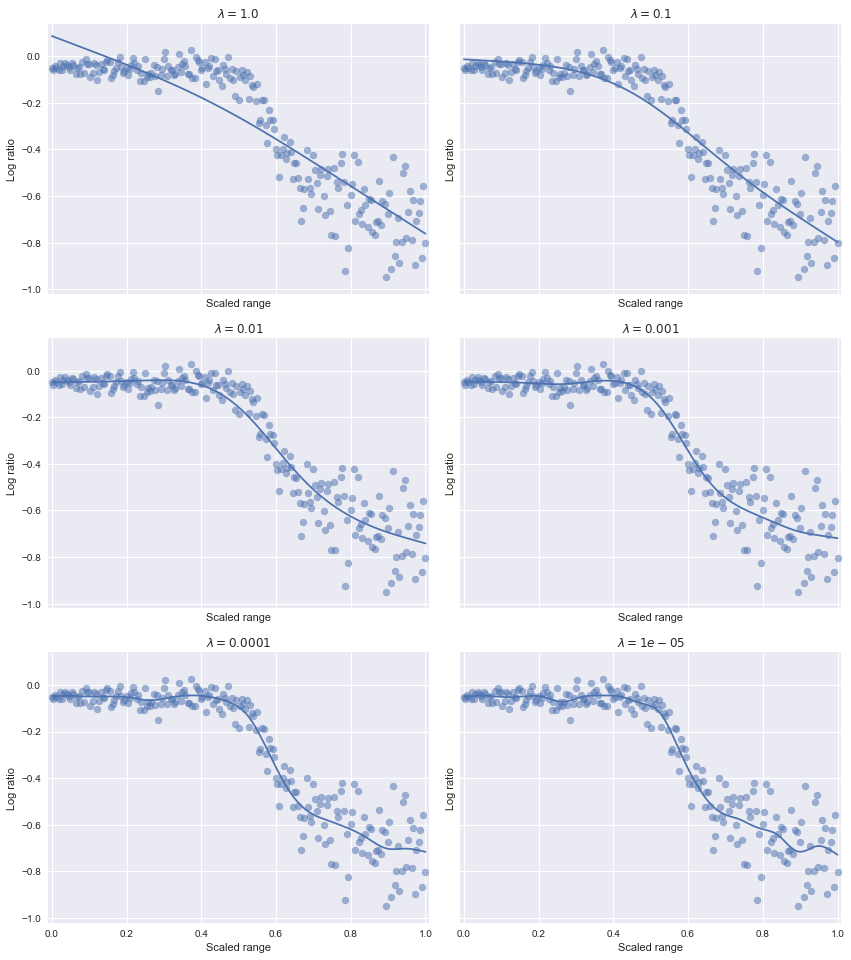

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, squeeze=True, figsize=(12, 13.5))

plot_lambdas = np.array([1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001])

plot_x = np.linspace(0, 1, 100)
plot_X = patsy.dmatrix('std_range + R_(std_range)', {'std_range': plot_x})

for lambda_, ax in zip(plot_lambdas, np.ravel(axes)):
    ax.scatter(df.std_range, df.logratio, c=blue, alpha=0.5);
    
    results = fit(y, X, B, lambda_=lambda_)
    ax.plot(plot_x, results.predict(plot_X));
    
    ax.set_xlim(-0.01, 1.01);
    ax.set_xlabel('Scaled range');
    
    ax.set_ylabel('Log ratio');
    
    ax.set_title(r'$\lambda = {}$'.format(lambda_));

fig.tight_layout();

We can see that as $\lambda$ decreases, the model becomes less smooth.  Visually, it seems that the optimal value of $\lambda$ lies somewhere between $10^{-2}$ and $10^{-4}$.  We need a rigorous way to choose the optimal value of $\lambda$.  As is often the case in such situations, we turn to [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)).  Specifically, we will use [generalized cross-validation](http://www.stat.wisc.edu/~wahba/ftp1/oldie/golub.heath.wahba.pdf) to choose the optimal value of $\lambda$.  The GCV score is given by

$$\operatorname{GCV}(\lambda) = \frac{n \sum_{i = 1}^n \left(y_i - \hat{y}_i\right)^2}{\left(n - \operatorname{tr} \mathbf{H}\right)^2}.$$

Here, $\hat{y}_i$ is the $i$-th predicted value, and $\mathbf{H}$ is upper left $n \times n$ submatrix of the the [influence matrix](https://en.wikipedia.org/wiki/Hat_matrix) for the OLS model $\mathbf{\tilde{y}} = \mathbf{\tilde{X}} + \varepsilon$.

In [16]:
def gcv_score(results):
    X = results.model.exog[:-(q + 2), :]
    n = X.shape[0]
    y = results.model.endog[:n]
    
    y_hat = results.predict(X)
    hat_matrix_trace = results.get_influence().hat_matrix_diag[:n].sum()
    
    return n * np.power(y - y_hat, 2).sum() / np.power(n - hat_matrix_trace, 2)

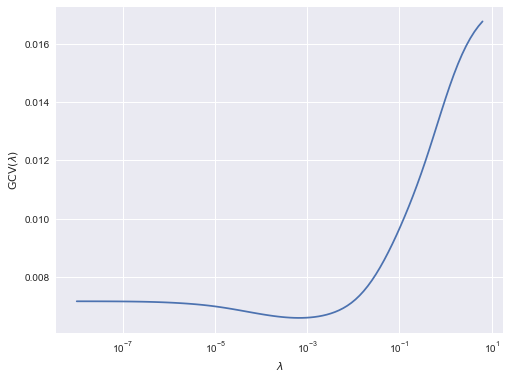

In [17]:
lambdas = np.logspace(0, 50, 100, base=1.5) * 1e-8
gcv_scores = np.array([gcv_score(fit(y, X, B, lambda_=lambda_)) for lambda_ in lambdas])

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(lambdas, gcv_scores);

ax.set_xscale('log');
ax.set_xlabel(r'$\lambda$');

ax.set_ylabel(r'$\operatorname{GCV}(\lambda)$');

In [18]:
lambda_best = lambdas[gcv_scores.argmin()]

lambda_best

0.00063458365729550153

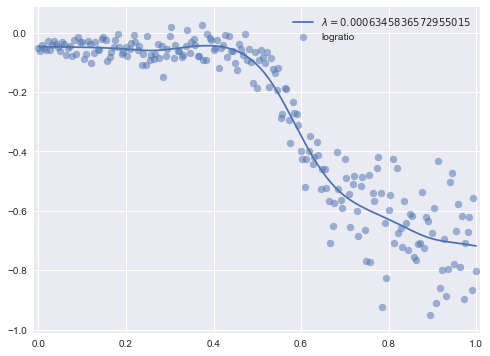

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df.std_range, df.logratio, c=blue, alpha=0.5);

results = fit(y, X, B, lambda_=lambda_best)
ax.plot(plot_x, results.predict(plot_X), label=r'$\lambda = {}$'.format(lambda_best));

ax.set_xlim(-0.01, 1.01);

ax.legend();

We have only scratched the surface of additive models, fitting a simple model of one variable with penalized regression splines. In general, additive models are quite powerful and flexible, while remaining quite interpretable.